In [1]:
import vrep 
import sys
import time 
import numpy as np
import skfuzzy as fuzz

from tank import *

In [2]:
vrep.simxFinish(-1) # closes all opened connections, in case any prevoius wasnt finished
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # start a connection

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

#create instance of Tank
tank=Tank(clientID)

Connected to remote API server


In [3]:
proximity_sensor="Proximity_sensor"


# get handle to proximity sensor
err_code,proximity_sensors_handle = vrep.simxGetObjectHandle(clientID,"Proximity_sensor", vrep.simx_opmode_blocking)
    
#read and print values from proximity sensors
#first reading should be done with simx_opmode_streaming, further with simx_opmode_buffer parameter

err_code,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,proximity_sensors_handle,vrep.simx_opmode_streaming)

In [4]:
tank.rightvelocity

0

In [5]:
err_code,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVecto = vrep.simxReadProximitySensor(clientID,proximity_sensors_handle,vrep.simx_opmode_buffer )

In [6]:
detectedPoint

[0.0, 0.0, 0.0]

In [7]:
np.linalg.norm(detectedPoint)

np.float64(0.0)

In [8]:
# proximity sensor value starts in this scene from above 7 and might be as low as 0 when buliding is hit
# we will define current speed of tank and distance from building as inputs to control systems and change in velocity as an output

In [9]:
# now with usage of new skyfuzzy control API 
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership

in_dist = ctrl.Antecedent(np.arange(0.4,7.5,0.1),'in_dist')
in_velo = ctrl.Antecedent(np.arange(0,10.1,0.1),'in_velo')
out_velo = ctrl.Consequent(np.arange(0,10.1,0.1),'out_velo')

out_velo.defuzzify_method = 'bisectorz'
# out_velo.defuzzify_method = 'centroid' # smoother but requires manual stop condition


# Custom membership functions can be built interactively with a familiar,
# Pythonic API

in_dist['low'] = fuzz.trimf(in_dist.universe,[0.4,0.4,3.5])
in_dist['medium'] = fuzz.trimf(in_dist.universe,[0.4,3.5,7.5])
in_dist['high'] = fuzz.trimf(in_dist.universe,[3.5,7.5,7.5])


in_velo['low'] = fuzz.trimf(in_velo.universe,[0,0,4])

in_velo['medium'] = fuzz.trimf(in_velo.universe,[0,4,10])

in_velo['high'] = fuzz.trimf(in_velo.universe,[4,10,10])

out_velo['low'] = fuzz.trimf(out_velo.universe,[0,0,4])

out_velo['medium'] = fuzz.trimf(out_velo.universe,[0,4,10])

out_velo['high'] = fuzz.trimf(out_velo.universe,[4,10,10])




c:\Users\akopa\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


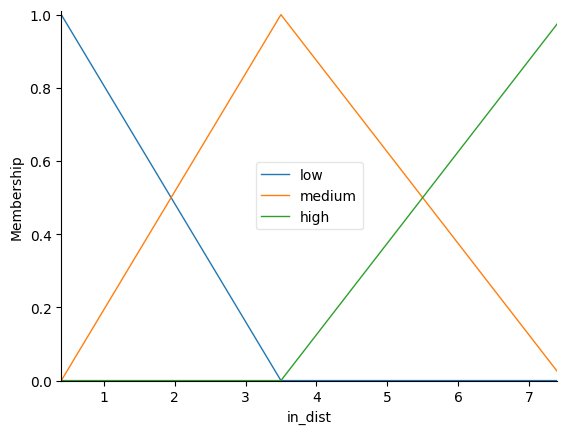

In [10]:
in_dist.view()

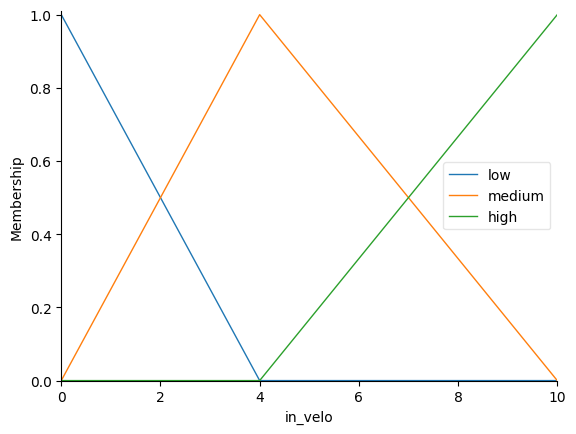

In [11]:
in_velo.view()

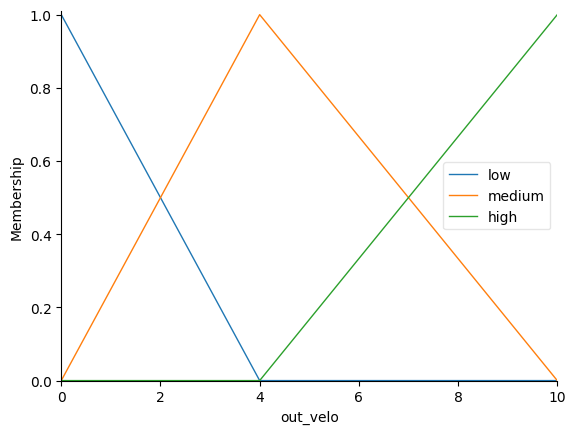

In [12]:
out_velo.view()

In [13]:
# dec_rule = ctrl.Rule(antecedent=((in_dist['low'] & in_velo['low']) | (in_dist['medium']&  in_velo['high']) | (in_dist['low'] & in_velo['high'])  | (in_dist['low'] & in_velo['medium'])),consequent = out_velo['low'])
dec_rule = ctrl.Rule(antecedent= in_dist['low'] | (in_dist['medium'] & in_velo['high']),consequent = out_velo['low'])

rul0 = ctrl.Rule(antecedent=(in_velo['medium'] & in_dist['medium']),consequent=out_velo['medium'])

acc_rule = ctrl.Rule(antecedent=in_dist['high'],consequent=out_velo['high'])
# acc_rule = ctrl.Rule(antecedent=((in_velo['low'] & in_dist['medium'])|(in_velo['medium'] & in_dist['high'])),consequent=out_velo['high'])


In [14]:
speed_ctrl = ctrl.ControlSystem([dec_rule,acc_rule,rul0])

velo_updater = ctrl.ControlSystemSimulation(speed_ctrl)

In [15]:


tank.forward(0)
#continue reading and printing values from proximity sensors
# right and left velocity seems to be the same so will be using right velocity if needed to read it 
# tank.rightvelocity()
velo = 0
counter = 0
while True: # read values for 5 seconds
    
    err_code,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,proximity_sensors_handle,vrep.simx_opmode_buffer )
    counter +=1
    if (err_code == 0):
       
        
        distance_data = np.linalg.norm(detectedPoint)
        if distance_data <= 0.4:
            tank.forward(0)
            print("Closer than 0.7; stopping the tank")
            break
        if counter % 5000 == 0:
            print("Proximity_sensor",distance_data,"Velocity",tank.rightvelocity)

        # controler 
        velo_updater.input['in_velo'] = tank.rightvelocity
        velo_updater.input['in_dist'] = distance_data
        velo_updater.compute()
        tank.forward(velo_updater.output['out_velo'])
      
    # print()   
time.sleep(20)
vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot) # stop the simulation in vrep     
    

Proximity_sensor 6.825437471710294 Velocity 7.595591038766965
Proximity_sensor 6.421638910800028 Velocity 6.985409402492748
Proximity_sensor 6.004719963086961 Velocity 6.068501068953707
Proximity_sensor 5.556798821648768 Velocity 5.452658188026213
Proximity_sensor 5.196599370662483 Velocity 5.120084585761545
Proximity_sensor 4.863399407144594 Velocity 4.9007663550691865
Proximity_sensor 4.579639981782868 Velocity 4.7625324322624305
Proximity_sensor 4.2787010196223765 Velocity 4.653147700442489
Proximity_sensor 4.044489273289669 Velocity 4.589094308126675
Proximity_sensor 3.773782665614757 Velocity 4.543898859014104
Proximity_sensor 3.5094787254491715 Velocity 4.53579010578198
Proximity_sensor 3.286399693098121 Velocity 4.535721654558614
Proximity_sensor 3.0703725936868502 Velocity 4.5468175287709585
Proximity_sensor 2.8670484641123983 Velocity 4.549595297614602
Proximity_sensor 2.648889871698328 Velocity 4.533354412273353
Proximity_sensor 2.415482141023545 Velocity 4.486667253006503
Pr

1